Example notebook to train regression model to make macronutrient predictions

In [ ]:
import pandas as pd
import os
import matplotlib
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101
from keras.models import Model
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#Check if GPU can be found and is built with cuda
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
#Store path
train_dir = '../FOODX-251_Dataset/train_set/'
val_dir = '../FOODX-251_Dataset/val_set/'
#Macornutrient data
macro_df = pd.read_csv('../FOODX-251_Dataset/macro_data_foodX251.csv')

#Merge macronutrient data with image labels for train and validation set. 
train_df = pd.read_csv('../FOODX-251_Dataset/train_labels.csv')

train_names, val_names = train_test_split(train_df, test_size = 0.15, random_state=42)
m_train_df = pd.merge(train_names, macro_df, on='label')


m_val_df = pd.merge(val_names, macro_df, on='label')
m_train_df = shuffle(m_train_df)
m_val_df = shuffle(m_val_df)
m_val_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
9949,train_014361.jpg,196,24.0,2.35,0.00,4.71
3435,train_070245.jpg,81,380.0,9.09,18.05,45.35
5867,train_035530.jpg,72,68.0,0.16,0.17,17.49
978,train_111913.jpg,232,207.0,7.46,10.28,21.20
65,train_038166.jpg,59,269.0,5.61,14.12,29.97


In [4]:
test_df = pd.read_csv('../FOODX-251_Dataset/val_labels.csv')
m_test_df = pd.merge(test_df, macro_df, on='label')
m_test_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
0,val_010323.jpg,247,339.0,4.07,19.24,39.84
1,val_010350.jpg,247,339.0,4.07,19.24,39.84
2,val_010389.jpg,247,339.0,4.07,19.24,39.84
3,val_010404.jpg,247,339.0,4.07,19.24,39.84
4,val_010471.jpg,247,339.0,4.07,19.24,39.84


In [5]:
print(m_train_df.shape)
print(m_val_df.shape)
print(m_test_df.shape)
m_train_df.groupby("label").count().mean()

(100703, 6)
(17772, 6)
(11994, 6)


img_name        401.207171
Energy          401.207171
Protein         401.207171
Fat             401.207171
Carbohydrate    401.207171
dtype: float64

In [6]:
scaler = MinMaxScaler(feature_range=(-0.99, 0.99))
m_train_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']] = scaler.fit_transform(m_train_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']])


m_val_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']] = scaler.fit_transform(m_val_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']])
m_train_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
32000,train_035508.jpg,72,-0.796733,-0.980458,-0.983268,-0.576258
91432,train_023325.jpg,17,0.343147,-0.244518,-0.919116,0.784194
93104,train_028221.jpg,82,-0.698127,-0.911277,-0.780516,-0.729548
36956,train_064621.jpg,191,-0.390478,0.423434,-0.813384,-0.816129
82923,train_087304.jpg,99,-0.619243,0.054867,-0.839520,-0.965634


In [7]:
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(100,100,3))

In [8]:
model = Sequential()
model.add(resnet)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 4, 4, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [9]:
opt = Adam(lr=0.00005)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 4, 4, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [10]:
#Set up keras generators for extracting image informationa and for preprocessing
columns=["Energy" , "Protein", "Fat", "Carbohydrate"]
#, "Protein", "Fat", "Carbohydrate"
train_datagen = ImageDataGenerator(
        rescale=1.0/255.0, 
    shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        rotation_range=0)
test_datagen=ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=m_train_df,
        directory="../FOODX-251_Dataset/train_set",
        x_col = 'img_name', 
        y_col = columns,
        batch_size = 64,
        seed = 42,
        shuffle=True,
        class_mode="raw",
        target_size=(100,100))  

valid_generator=train_datagen.flow_from_dataframe(
        dataframe=m_val_df,
        directory="../FOODX-251_Dataset/train_set",
        x_col='img_name',
        y_col=columns,
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(100,100))

test_generator=test_datagen.flow_from_dataframe(
        dataframe=m_test_df,
        directory="../FOODX-251_Dataset/val_set",
        x_col='img_name',
        y_col=columns,
        batch_size=1,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(100,100))
#plt.imshow(images[1])

Found 100703 validated image filenames.
Found 17772 validated image filenames.
Found 11994 validated image filenames.


In [11]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=25)

In [12]:
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1), early_stopping_callback]

In [13]:
#Fit the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    callbacks=callbacks,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 6987s 4s/step - loss: 0.3354 - mean_absolute_error: 0.4272 - val_loss: 0.1708 - val_mean_absolute_error: 0.3375
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 421s 268ms/step - loss: 0.1746 - mean_absolute_error: 0.3313 - val_loss: 0.1876 - val_mean_absolute_error: 0.3260
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 417s 265ms/step - loss: 0.1719 - mean_absolute_error: 0.3263 - val_loss: 0.1421 - val_mean_absolute_error: 0.3154
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 419s 266ms/step - loss: 0.1628 - mean_absolute_error: 0.3149 - val_loss: 0.1476 - val_mean_absolute

1573/1573 [==============================] - 430s 274ms/step - loss: 0.0753 - mean_absolute_error: 0.2036 - val_loss: 0.1166 - val_mean_absolute_error: 0.2534
Epoch 33/50

Epoch 00033: LearningRateScheduler setting learning rate to 5.000000058430487e-08.
1573/1573 [==============================] - 431s 274ms/step - loss: 0.0752 - mean_absolute_error: 0.2033 - val_loss: 0.1277 - val_mean_absolute_error: 0.2530
Epoch 34/50

Epoch 00034: LearningRateScheduler setting learning rate to 5.000000058430487e-08.
1573/1573 [==============================] - 421s 268ms/step - loss: 0.0754 - mean_absolute_error: 0.2034 - val_loss: 0.1226 - val_mean_absolute_error: 0.2540
Epoch 35/50

Epoch 00035: LearningRateScheduler setting learning rate to 5.000000058430487e-08.
1573/1573 [==============================] - 433s 275ms/step - loss: 0.0752 - mean_absolute_error: 0.2034 - val_loss: 0.0981 - val_mean_absolute_error: 0.2524
Epoch 36/50

Epoch 00036: LearningRateScheduler setting learning rate to 5.0

In [26]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

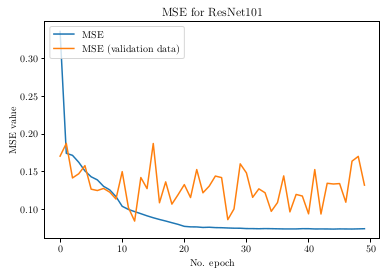

In [27]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MSE ')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for ResNet101')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [16]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

11994/11994 [==============================] - 433s 36ms/step


In [17]:
results=pd.DataFrame(pred, columns=columns)

In [18]:
resultsRescaled = scaler.inverse_transform(results)

In [19]:
results.head()

,Energy,Protein,Fat,Carbohydrate
0,0.090324,-0.577337,-0.409935,-0.139402
1,-0.353465,0.278056,-0.662941,-0.818455
2,0.259803,-0.598554,-0.351208,0.064855
3,0.183168,-0.608820,-0.373798,-0.003037
4,-0.338138,-0.507926,-0.684471,-0.440854


In [20]:
# loss, t= model.evaluate_generator(test_generator,
#     steps=STEP_SIZE_TEST,
#     verbose=1)
print(resultsRescaled)

[[292.90042     6.9193935  14.648109   35.957115 ]
 [180.384      21.26236     8.259061    7.2516656]
 [335.86914     6.563643   16.131111   44.591587 ]
 ...
 [176.26872    11.441427    9.656847   12.084336 ]
 [159.86435    23.457506    3.5349252  12.166815 ]
 [134.5573     13.402769    5.673326    7.734783 ]]


In [21]:
RSMEArray = []
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Energy'], resultsRescaled[:,0])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Protein'], resultsRescaled[:,1])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Fat'], resultsRescaled[:,2])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Carbohydrate'], resultsRescaled[:,3])))
print("RSME for Energy: "  + str(RSMEArray[0]) + " Relative RSME: " + str(RSMEArray[0]/m_test_df['Energy'].mean()))
print("RSME for Protein: "  + str(RSMEArray[1]) + " Relative RSME: " + str(RSMEArray[1]/m_test_df['Protein'].mean()))
print("RSME for Fat: "  + str(RSMEArray[2]) + " Relative RSME: " + str(RSMEArray[2]/m_test_df['Fat'].mean()))
print("RSME for Carbohydrate: "  + str(RSMEArray[3]) + " Relative RSME: " + str(RSMEArray[3]/m_test_df['Carbohydrate'].mean()))
print()
print()
print(sqrt(mean_squared_error(m_test_df['Energy'], resultsRescaled[:,0])/mean_squared_error(m_test_df['Energy'], resultsRescaled[:,0]))

RSME for Energy: 91.93785417746061 Relative RSME: 0.4206456622824417
RSME for Protein: 5.5594443763289165 Relative RSME: 0.5707082420783735
RSME for Fat: 7.453956000743086 Relative RSME: 0.6882583370843486
RSME for Carbohydrate: 15.805861044344672 Relative RSME: 0.7646141545705555




In [22]:


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(m_train_df['Energy'], m_train_df[['Energy' , 'Protein' , 'Fat', 'Carbohydrate']])
pred = dummy_regr.predict(m_test_df[['Energy' , 'Protein' , 'Fat', 'Carbohydrate']])
pred = scaler.inverse_transform(pred)

print("Results for using mean as predicted")
print("RSME Energy: "  + str(sqrt(mean_squared_error(m_test_df['Energy'], pred[:,0]))))
print("RSME Protein: "  + str(sqrt(mean_squared_error(m_test_df['Protein'], pred[:,1]))))
print("RSME Fat: "  + str(sqrt(mean_squared_error(m_test_df['Fat'], pred[:,2]))))
print("RSME Carbohydrate: "  + str(sqrt(mean_squared_error(m_test_df['Carbohydrate'], pred[:,3]))))



Results for using mean as predicted
RSME Energy: 111.49862486903056
RSME Protein: 6.728070397843198
RSME Fat: 8.487148321355496
RSME Carbohydrate: 19.356375952900237


In [25]:
print(sqrt(mean_squared_error(m_test_df['Energy'], resultsRescaled[:,0]) / mean_squared_error(m_test_df['Energy'],pred[:,0])))
print(sqrt(mean_squared_error(m_test_df['Protein'], resultsRescaled[:,1]) / mean_squared_error(m_test_df['Protein'],pred[:,1])))
print(sqrt(mean_squared_error(m_test_df['Fat'], resultsRescaled[:,2]) / mean_squared_error(m_test_df['Fat'],pred[:,2])))
print(sqrt(mean_squared_error(m_test_df['Carbohydrate'], resultsRescaled[:,3]) / mean_squared_error(m_test_df['Carbohydrate'],pred[:,3])))

0.8245649153561616
0.8263059164944372
0.8782639019029895
0.8165712984085961
